In [88]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import mlflow
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [89]:
data = pd.read_csv("../DataCleaning/cleaned_data.csv", parse_dates=['Date'])
data = data.sort_values("Date")

In [90]:
data.columns

Index(['Product_ID', 'Category', 'Price', 'Date', 'Season',
       'Market_Trend_Index', 'Competitor_Activity_Score',
       'Consumer_Confidence_Index', 'Product_Specification_1',
       'Product_Specification_2', 'Sales_Volume', 'Total_Amount', 'Recency',
       'Frequency', 'Monetary', 'Sales_Volume_lag1', 'Sales_Volume_lag7',
       'Sales_Volume_lag30', 'Price_lag1', 'Price_lag7', 'Price_lag30',
       'Market_Trend_Index_lag1', 'Market_Trend_Index_lag7',
       'Market_Trend_Index_lag30', 'Competitor_Activity_Score_lag1',
       'Competitor_Activity_Score_lag7', 'Competitor_Activity_Score_lag30',
       'Consumer_Confidence_Index_lag1', 'Consumer_Confidence_Index_lag7',
       'Consumer_Confidence_Index_lag30'],
      dtype='object')

### Remove misleading columns

In [91]:
data.drop(columns=['Recency', 'Frequency', 'Monetary'], inplace=True)

In [92]:
data['Product_Specification_1'].value_counts()

Product_Specification_1
Spec_C    38614
Spec_B    38569
Spec_A    38190
Name: count, dtype: int64

In [93]:
data.drop(columns=['Product_Specification_1'], inplace=True)

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115373 entries, 110294 to 108213
Data columns (total 26 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Product_ID                       115373 non-null  int64         
 1   Category                         115373 non-null  object        
 2   Price                            115373 non-null  float64       
 3   Date                             115373 non-null  datetime64[ns]
 4   Season                           115373 non-null  object        
 5   Market_Trend_Index               115373 non-null  float64       
 6   Competitor_Activity_Score        115373 non-null  float64       
 7   Consumer_Confidence_Index        115373 non-null  float64       
 8   Product_Specification_2          115373 non-null  object        
 9   Sales_Volume                     115373 non-null  int64         
 10  Total_Amount                     115373 non-

### Split the data

In [95]:
train_size = int(len(data) * 0.8)

train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

### Feature Selection with Mutual Info

In [96]:
mi_data = data.drop(columns=['Date', 'Product_ID', 'Category', 'Season', 'Product_Specification_2'])

<Axes: ylabel='Feature'>

<Figure size 1000x800 with 0 Axes>

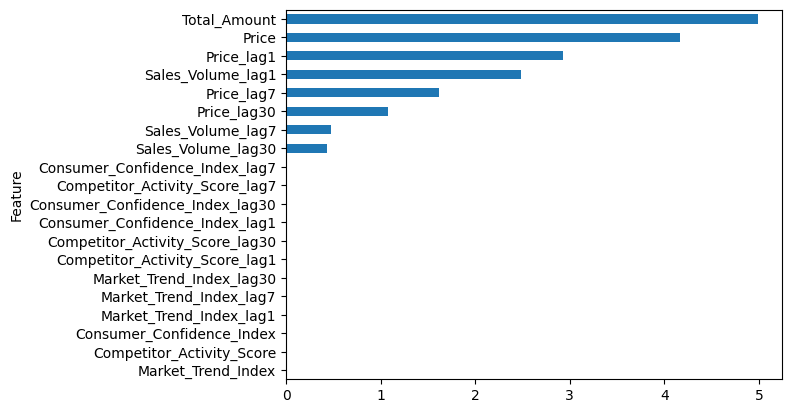

In [97]:
target = mi_data['Sales_Volume']
var = mi_data.drop(columns=['Sales_Volume'])

from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(var, target, random_state=42)
mi_df = pd.DataFrame(
    {
        'Feature': var.columns,
        'MI_Score': mi_scores
    }
).sort_values('MI_Score', ascending=True)

plt.figure(figsize=(10, 8))
mi_df.head(20).plot(x='Feature', y='MI_Score', kind='barh', legend=False)

### Split data with external features sampled on daily basis

In [45]:
data.columns

Index(['Product_ID', 'Category', 'Price', 'Date', 'Season',
       'Market_Trend_Index', 'Competitor_Activity_Score',
       'Consumer_Confidence_Index', 'Product_Specification_2', 'Sales_Volume',
       'Total_Amount', 'Sales_Volume_lag1', 'Sales_Volume_lag7',
       'Sales_Volume_lag30', 'Price_lag1', 'Price_lag7', 'Price_lag30',
       'Market_Trend_Index_lag1', 'Market_Trend_Index_lag7',
       'Market_Trend_Index_lag30', 'Competitor_Activity_Score_lag1',
       'Competitor_Activity_Score_lag7', 'Competitor_Activity_Score_lag30',
       'Consumer_Confidence_Index_lag1', 'Consumer_Confidence_Index_lag7',
       'Consumer_Confidence_Index_lag30'],
      dtype='object')

In [46]:
print(train_size)

92298


In [47]:
top_features = mi_df['Feature'].head(20).to_list()

data = pd.get_dummies(data, columns=['Category'], drop_first=False)
data = pd.get_dummies(data, columns=['Season'], drop_first=False)
data = pd.get_dummies(data, columns=['Product_Specification_2'], drop_first=False)

bool_cols = data.select_dtypes(include=['bool']).columns
data[bool_cols] = data[bool_cols].astype(int)

category_cols = [col for col in data.columns if col.startswith('Category_')]
season_cols = [col for col in data.columns if col.startswith('Season_')]
product_specification_2_cols = [col for col in data.columns if col.startswith('Product_Specification_2_')]

exog_features = top_features + category_cols + season_cols + product_specification_2_cols

data = data.set_index('Date')

target = data['Sales_Volume']
exog = data[exog_features]

train_size = int(len(target) * 0.8)

X_train = exog.iloc[:train_size]
y_train = target.iloc[:train_size]

X_test = exog.iloc[train_size:]
y_test = target.iloc[train_size:]

In [48]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

92298 92298 23075 23075


### Train SARIMAX using MLFLOW (Weekly)

In [50]:
mlflow.set_experiment("ElectroTech Forecasting (Weekly)")

<Experiment: artifact_location=('file:///c:/Users/hilla.HILLARY/Projects/Amdari/Forecasting Sales for '
 'Fast-Moving Consumer Electronics/ElectroTech-Forecasting-Data/model/mlruns/1'), creation_time=1766512894311, experiment_id='1', last_update_time=1766512894311, lifecycle_stage='active', name='ElectroTech Forecasting (Weekly)', tags={}>

sarimax_mae: 14.905575953320346
sarimax_rmse: 19.14243067087763
sarimax_r2: 0.8626529597844015


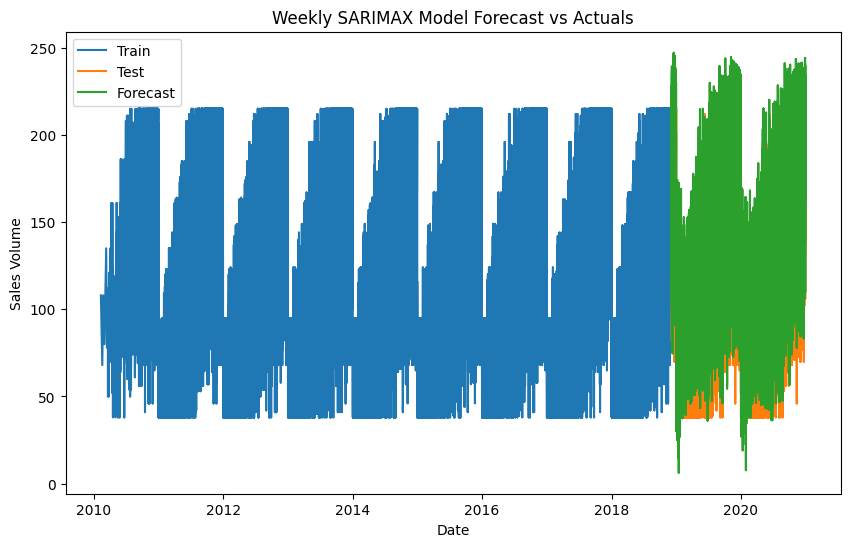

In [51]:
with mlflow.start_run(run_name="Weekly SARIMAX model"):
    sarimax_model = SARIMAX(
        endog=y_train,
        exog=X_train,
        order=(1, 1, 1),
        seasonal_order=(2, 0, 0, 7),
    ).fit(disp=False)

    sarimax_forecast = sarimax_model.forecast(steps=len(y_test), exog=X_test)
    sarimax_mae = mean_absolute_error(y_test, sarimax_forecast)
    sarimax_rmse = np.sqrt(mean_squared_error(y_test, sarimax_forecast))
    sarimax_r2 = r2_score(y_test, sarimax_forecast)

    print("sarimax_mae:", sarimax_mae)
    print("sarimax_rmse:", sarimax_rmse)
    print("sarimax_r2:", sarimax_r2)

    mlflow.log_param("order", (1, 1, 1))
    mlflow.log_param("seasonal_order", (2, 0, 0, 7))
    mlflow.log_param("exog_features", exog_features)

    mlflow.log_metric("MAE", sarimax_mae)
    mlflow.log_metric("RMSE", sarimax_rmse)
    mlflow.log_metric("R2", sarimax_r2)

    with open("weekly_sarimax_model.pkl", "wb") as f:
        pickle.dump(sarimax_model, f)

    mlflow.log_artifact("weekly_sarimax_model.pkl")

    plt.figure(figsize=(10, 6))
    plt.plot(y_train.index, y_train, label="Train")  # train
    plt.plot(y_test.index, y_test, label="Test")  # test
    plt.plot(y_test.index, sarimax_forecast, label="Forecast")  # forecast
    plt.legend()
    plt.title("Weekly SARIMAX Model Forecast vs Actuals")
    plt.xlabel("Date")
    plt.ylabel("Sales Volume")
    plt.savefig("weekly_sales_volume_sarimax_forecast.png")

    mlflow.log_artifact("weekly_sales_volume_sarimax_forecast.png")
    plt.show()

### Hyperparameter Tuning (Weekly)

In [17]:
from pmdarima import auto_arima

model = auto_arima(
    y_train,
    exogenous=X_train,
    seasonal=True,
    m=7,
    start_p=0, max_p=2,
    start_q=0, max_q=2,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    d=None,
    D=None,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    
    stepwise=False, 
    random=True,  
    n_fits=30,   
    random_state=42 
)

print(model.summary())
print(f"Best order: {model.order}")
print(f"Best seasonal_order: {model.seasonal_order}")

 ARIMA(2,1,0)(1,0,2)[7] intercept   : AIC=923577.035, Time=11.80 sec
 ARIMA(2,1,1)(2,0,0)[7] intercept   : AIC=900685.926, Time=63.65 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=960474.714, Time=0.81 sec
 ARIMA(1,1,2)(0,0,2)[7] intercept   : AIC=900690.624, Time=56.37 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=960477.486, Time=16.30 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=900684.841, Time=11.74 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=900688.735, Time=37.65 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=900685.611, Time=11.06 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=900686.182, Time=29.52 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=934452.003, Time=6.36 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=934453.395, Time=14.54 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=900684.750, Time=7.22 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=900683.936, Time=47.42 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=900687.601, Time=21.32 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   :

MemoryError: Unable to allocate 204. MiB for an array with shape (17, 17, 92298) and data type float64

### Split data with external features sampled on weekly basis

In [98]:
data.columns

Index(['Product_ID', 'Category', 'Price', 'Date', 'Season',
       'Market_Trend_Index', 'Competitor_Activity_Score',
       'Consumer_Confidence_Index', 'Product_Specification_2', 'Sales_Volume',
       'Total_Amount', 'Sales_Volume_lag1', 'Sales_Volume_lag7',
       'Sales_Volume_lag30', 'Price_lag1', 'Price_lag7', 'Price_lag30',
       'Market_Trend_Index_lag1', 'Market_Trend_Index_lag7',
       'Market_Trend_Index_lag30', 'Competitor_Activity_Score_lag1',
       'Competitor_Activity_Score_lag7', 'Competitor_Activity_Score_lag30',
       'Consumer_Confidence_Index_lag1', 'Consumer_Confidence_Index_lag7',
       'Consumer_Confidence_Index_lag30'],
      dtype='object')

In [99]:
print(train_size)

92298


In [100]:
top_features = mi_df['Feature'].head(20).to_list()

data = pd.get_dummies(data, columns=['Category'], drop_first=False)
data = pd.get_dummies(data, columns=['Season'], drop_first=False)
data = pd.get_dummies(data, columns=['Product_Specification_2'], drop_first=False)

bool_cols = data.select_dtypes(include=['bool']).columns
data[bool_cols] = data[bool_cols].astype(int)

category_cols = [col for col in data.columns if col.startswith('Category_')]
season_cols = [col for col in data.columns if col.startswith('Season_')]
product_specification_2_cols = [col for col in data.columns if col.startswith('Product_Specification_2_')]


exog_features = top_features + category_cols + season_cols + product_specification_2_cols

data = data.set_index('Date')

weekly_target = data['Sales_Volume'].resample('W').mean()
weekly_exog = data[exog_features].resample('W').mean()

train_size = int(len(weekly_target) * 0.8)

X_train = weekly_exog.iloc[:train_size]
y_train = weekly_target.iloc[:train_size]

X_test = weekly_exog.iloc[train_size:]
y_test = weekly_target.iloc[train_size:]

In [65]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

455 455 114 114


### Train SARIMAX using MLFLOW (Monthly)

In [67]:
mlflow.set_experiment("ElectroTech Forecasting (Monthly)")

<Experiment: artifact_location=('file:///c:/Users/hilla.HILLARY/Projects/Amdari/Forecasting Sales for '
 'Fast-Moving Consumer Electronics/ElectroTech-Forecasting-Data/model/mlruns/2'), creation_time=1766513254142, experiment_id='2', last_update_time=1766513254142, lifecycle_stage='active', name='ElectroTech Forecasting (Monthly)', tags={}>

sarimax_mae: 0.7599641930555447
sarimax_rmse: 1.0284282126336806
sarimax_r2: 0.9993830716320663


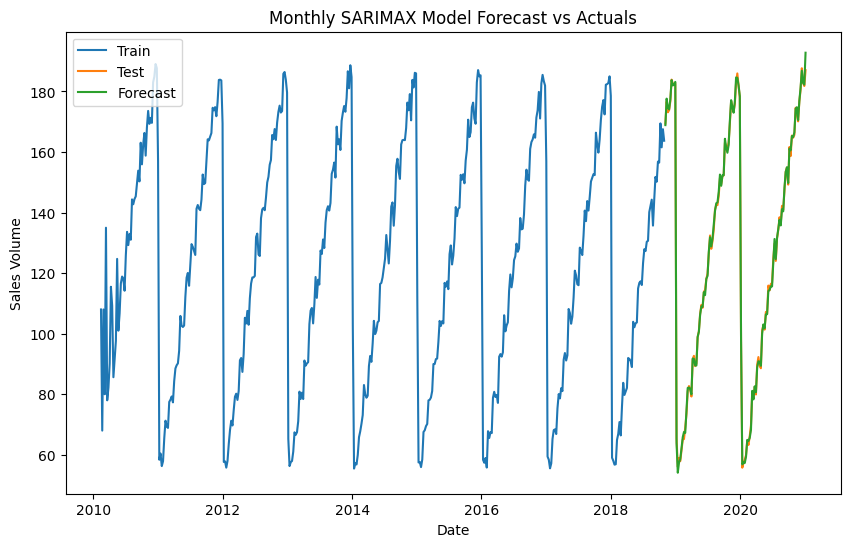

In [68]:
with mlflow.start_run(run_name="Monthly SARIMAX model"):
    sarimax_model = SARIMAX(
        endog=y_train,
        exog=X_train,
        order=(2, 0, 1),
        seasonal_order=(0, 0, 1
        , 4),
    ).fit(disp=False)

    sarimax_forecast = sarimax_model.forecast(steps=len(y_test), exog=X_test)
    sarimax_mae = mean_absolute_error(y_test, sarimax_forecast)
    sarimax_rmse = np.sqrt(mean_squared_error(y_test, sarimax_forecast))
    sarimax_r2 = r2_score(y_test, sarimax_forecast)

    print("sarimax_mae:", sarimax_mae)
    print("sarimax_rmse:", sarimax_rmse)
    print("sarimax_r2:", sarimax_r2)


    mlflow.log_param("order", (2, 0, 1))
    mlflow.log_param("seasonal_order", (0, 0, 1, 4))
    mlflow.log_param("exog_features", exog_features)

    mlflow.log_metric("MAE", sarimax_mae)
    mlflow.log_metric("RMSE", sarimax_rmse)
    mlflow.log_metric("R2", sarimax_r2)

    with open("monthly_sarimax_model.pkl", 'wb') as f:
        pickle.dump(sarimax_model, f)

    mlflow.log_artifact("monthly_sarimax_model.pkl")

    plt.figure(figsize=(10, 6))
    plt.plot(y_train.index, y_train, label="Train") # train
    plt.plot(y_test.index, y_test, label="Test") # test
    plt.plot(y_test.index, sarimax_forecast, label="Forecast") # forecast
    plt.legend()
    plt.title("Monthly SARIMAX Model Forecast vs Actuals")
    plt.xlabel("Date")
    plt.ylabel("Sales Volume")
    plt.savefig("monthly_sales_volume_sarimax_forecast.png")

    mlflow.log_artifact("monthly_sales_volume_sarimax_forecast.png")
    plt.show()

### Hyperparameter Tuning (Weekly)

In [32]:
from pmdarima import auto_arima

model = auto_arima(
    y_train,
    exogenous=X_train,
    seasonal=True,
    m=4,
    start_p=0, max_p=2,
    start_q=0, max_q=2,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    d=None,
    D=None,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    
    stepwise=False, 
    random=True,  
    n_fits=30,   
    random_state=42 
)

print(model.summary())
print(f"Best order: {model.order}")
print(f"Best seasonal_order: {model.seasonal_order}")

 ARIMA(2,0,0)(1,0,2)[4] intercept   : AIC=3782.773, Time=0.46 sec
 ARIMA(2,0,1)(2,0,0)[4] intercept   : AIC=3780.940, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=4632.867, Time=0.02 sec
 ARIMA(1,0,2)(0,0,2)[4] intercept   : AIC=3780.197, Time=0.26 sec
 ARIMA(0,0,0)(1,0,2)[4] intercept   : AIC=4407.163, Time=0.35 sec
 ARIMA(2,0,2)(0,0,0)[4] intercept   : AIC=3780.786, Time=0.08 sec
 ARIMA(0,0,1)(2,0,1)[4] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,1)(1,0,0)[4] intercept   : AIC=4051.478, Time=0.13 sec
 ARIMA(2,0,2)(1,0,0)[4] intercept   : AIC=3780.614, Time=0.37 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=3793.395, Time=0.21 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=3793.553, Time=0.38 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=4221.217, Time=0.06 sec
 ARIMA(1,0,1)(2,0,0)[4] intercept   : AIC=3783.998, Time=0.32 sec
 ARIMA(0,0,1)(1,0,1)[4] intercept   : AIC=4046.071, Time=0.22 sec
 ARIMA(1,0,0)(2,0,2)[4] intercept   : AIC=3795.321, Time=0.47 sec
 ARIMA(0,0,2)(2

### Train SARIMAX using MLFLOW (Quarterly)

In [101]:
mlflow.set_experiment("ElectroTech Forecasting (Quarterly)")


<Experiment: artifact_location=('file:///c:/Users/hilla.HILLARY/Projects/Amdari/Forecasting Sales for '
 'Fast-Moving Consumer Electronics/ElectroTech-Forecasting-Data/model/mlruns/3'), creation_time=1766513373885, experiment_id='3', last_update_time=1766513373885, lifecycle_stage='active', name='ElectroTech Forecasting (Quarterly)', tags={}>

sarimax_mae: 0.7593622971291922
sarimax_rmse: 1.0271409517082064
sarimax_r2: 0.9993846150568061


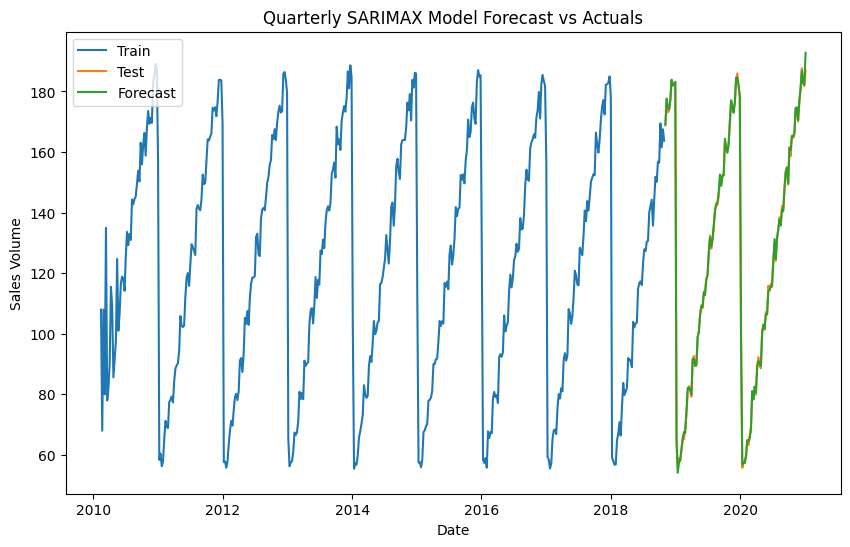

In [102]:
with mlflow.start_run(run_name="Quarterly SARIMAX model"):
    sarimax_model = SARIMAX(
        endog=y_train,
        exog=X_train,
        order=(2, 0, 1),
        seasonal_order=(0, 0, 2
        , 13),
    ).fit(disp=False)

    sarimax_forecast = sarimax_model.forecast(steps=len(y_test), exog=X_test)
    sarimax_mae = mean_absolute_error(y_test, sarimax_forecast)
    sarimax_rmse = np.sqrt(mean_squared_error(y_test, sarimax_forecast))
    sarimax_r2 = r2_score(y_test, sarimax_forecast)

    print("sarimax_mae:", sarimax_mae)
    print("sarimax_rmse:", sarimax_rmse)
    print("sarimax_r2:", sarimax_r2)


    mlflow.log_param("order", (2, 0, 1))
    mlflow.log_param("seasonal_order", (0, 0, 2, 13))
    mlflow.log_param("exog_features", exog_features)

    mlflow.log_metric("MAE", sarimax_mae)
    mlflow.log_metric("RMSE", sarimax_rmse)
    mlflow.log_metric("R2", sarimax_r2)

    with open("quarterly_sarimax_model.pkl", 'wb') as f:
        pickle.dump(sarimax_model, f)

    mlflow.log_artifact("quarterly_sarimax_model.pkl")

    plt.figure(figsize=(10, 6))
    plt.plot(y_train.index, y_train, label="Train") # train
    plt.plot(y_test.index, y_test, label="Test") # test
    plt.plot(y_test.index, sarimax_forecast, label="Forecast") # forecast
    plt.legend()
    plt.title("Quarterly SARIMAX Model Forecast vs Actuals")
    plt.xlabel("Date")
    plt.ylabel("Sales Volume")
    plt.savefig("quarterly_sales_volume_sarimax_forecast.png")

    mlflow.log_artifact("quarterly_sales_volume_sarimax_forecast.png")
    plt.show()

In [48]:
from pmdarima import auto_arima

model = auto_arima(
    y_train,
    exogenous=X_train,
    seasonal=True,
    m=3,
    start_p=0, max_p=2,
    start_q=0, max_q=2,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    d=None,
    D=None,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    
    stepwise=False, 
    random=True,  
    n_fits=30,   
    random_state=42 
)

print(model.summary())
print(f"Best order: {model.order}")
print(f"Best seasonal_order: {model.seasonal_order}")

 ARIMA(2,0,0)(1,0,2)[3] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,0,1)(2,0,0)[3] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[3] intercept   : AIC=1064.566, Time=0.01 sec
 ARIMA(1,0,2)(0,0,2)[3] intercept   : AIC=1029.601, Time=0.05 sec
 ARIMA(0,0,0)(1,0,2)[3] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[3] intercept   : AIC=1028.360, Time=0.08 sec
 ARIMA(0,0,1)(2,0,1)[3] intercept   : AIC=1022.984, Time=0.11 sec
 ARIMA(0,0,1)(1,0,0)[3] intercept   : AIC=1031.807, Time=0.05 sec
 ARIMA(2,0,2)(1,0,0)[3] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[3] intercept   : AIC=1028.677, Time=0.09 sec
 ARIMA(1,0,0)(2,0,1)[3] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[3] intercept   : AIC=1032.096, Time=0.02 sec
 ARIMA(1,0,1)(2,0,0)[3] intercept   : AIC=1022.229, Time=0.13 sec
 ARIMA(0,0,1)(1,0,1)[3] intercept   : AIC=1029.914, Time=0.07 sec
 ARIMA(1,0,0)(2,0,2)[3] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,2)(2,0,1)[3] intercept   : AI

### Train SARIMAX using MLFLOW (Annually)

In [103]:
mlflow.set_experiment("ElectroTech Forecasting (Annually)")

<Experiment: artifact_location=('file:///c:/Users/hilla.HILLARY/Projects/Amdari/Forecasting Sales for '
 'Fast-Moving Consumer Electronics/ElectroTech-Forecasting-Data/model/mlruns/4'), creation_time=1766513432720, experiment_id='4', last_update_time=1766513432720, lifecycle_stage='active', name='ElectroTech Forecasting (Annually)', tags={}>

sarimax_mae: 0.7833156399334502
sarimax_rmse: 1.011974380731864
sarimax_r2: 0.9994026542026022


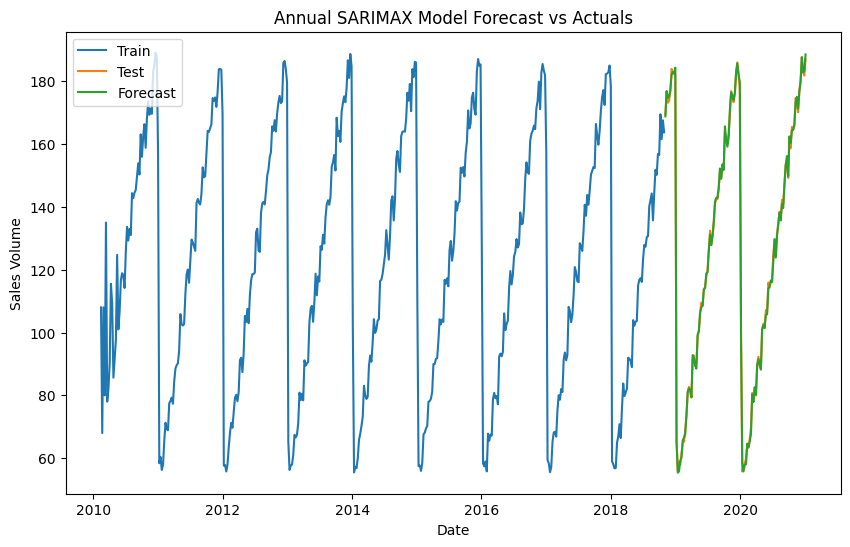

In [104]:
with mlflow.start_run(run_name="Annual SARIMAX model"):
    sarimax_model = SARIMAX(
        endog=y_train,
        exog=X_train,
        order=(0, 1, 1),
        seasonal_order=(1, 1, 0
        , 52),
    ).fit(disp=False)

    sarimax_forecast = sarimax_model.forecast(steps=len(y_test), exog=X_test)
    sarimax_mae = mean_absolute_error(y_test, sarimax_forecast)
    sarimax_rmse = np.sqrt(mean_squared_error(y_test, sarimax_forecast))
    sarimax_r2 = r2_score(y_test, sarimax_forecast)

    print("sarimax_mae:", sarimax_mae)
    print("sarimax_rmse:", sarimax_rmse)
    print("sarimax_r2:", sarimax_r2)


    mlflow.log_param("order", (0, 1, 1))
    mlflow.log_param("seasonal_order", (1, 1, 0, 52))
    mlflow.log_param("exog_features", exog_features)

    mlflow.log_metric("MAE", sarimax_mae)
    mlflow.log_metric("RMSE", sarimax_rmse)
    mlflow.log_metric("R2", sarimax_r2)

    with open("annual_sarimax_model.pkl", 'wb') as f:
        pickle.dump(sarimax_model, f)

    mlflow.log_artifact("annual_sarimax_model.pkl")

    plt.figure(figsize=(10, 6))
    plt.plot(y_train.index, y_train, label="Train") # train
    plt.plot(y_test.index, y_test, label="Test") # test
    plt.plot(y_test.index, sarimax_forecast, label="Forecast") # forecast
    plt.legend()
    plt.title("Annual SARIMAX Model Forecast vs Actuals")
    plt.xlabel("Date")
    plt.ylabel("Sales Volume")
    plt.savefig("annual_sales_volume_sarimax_forecast.png")

    mlflow.log_artifact("annual_sales_volume_sarimax_forecast.png")
    plt.show()

### Hyperparameter Tuning using Auto ARIMA (Annually)

In [51]:
from pmdarima import auto_arima

model = auto_arima(
    y_train,
    exogenous=X_train,
    seasonal=True,
    m=12,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    d=None,
    D=None,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    
    stepwise=False, 
    random=True,  
    n_fits=30,   
    random_state=42 
)

print(model.summary())
print(f"Best order: {model.order}")
print(f"Best seasonal_order: {model.seasonal_order}")

 ARIMA(2,1,3)(0,1,0)[12]             : AIC=453.671, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=460.502, Time=0.02 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=453.842, Time=0.13 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=452.170, Time=0.13 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=448.202, Time=0.04 sec
 ARIMA(1,1,3)(0,1,1)[12]             : AIC=450.591, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=448.613, Time=0.04 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=453.185, Time=0.02 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=453.284, Time=0.05 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=452.202, Time=0.12 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=449.902, Time=0.03 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=451.899, Time=0.08 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=451.346, Time=0.16 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=451.898, Time=0.09 sec
 ARIMA(2,1,1)(

The annual seasonality observed during EDA explains why the SARIMAX model with yearly seasonality performs best.